# more neuron_with dropout(0.2_more_tranformation_

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import time
from torch.optim import Adam
import torch.nn.functional as F


In [2]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
batch_size = 10
learning_rate = 0.001

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                             download=True, transform=transform)

# Splitting the training set into train and validation sets
train_size = int(0.8 * len(train_dataset)) # Using 80% for training
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 169001437/169001437 [00:04<00:00, 36144956.43it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, dropout_prob=0.2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(1024, 512)
        self.bn5 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)  # Applying dropout after activation function

        x = F.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)  # Applying dropout after activation function

        x = self.fc3(x)
        return x

# Ensure that the device variable is defined before this line
model = ConvNet().to(device)


In [5]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.best_model = None  # Store the best model state

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model = model.state_dict()  # Update the best model state
            self.counter = 0

In [6]:


# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)




In [ ]:
# Initialization for training and validation
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

early_stopping = EarlyStopping(patience=7, verbose=True)

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss/len(train_loader))

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss/len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}%, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {val_accuracy}%')

    # Early stopping check
    early_stopping(val_loss/len(val_loader), model) # use average validation loss
    if early_stopping.early_stop:
        print("Early stopping")
        break

end_time = time.time()

# Save the best model at the end of the training
try:
    if early_stopping.best_model:
        torch.save(early_stopping.best_model, '/content/drive/My Drive/checkpoint.pt')
        print("Best model saved to '/content/drive/My Drive/checkpoint.pt'")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")


# Loading the best model weights
print("Loading best model weights...")
try:
    model.load_state_dict(early_stopping.best_model)
    print("Best model weights loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading the model weights: {e}")

print(f"Total training time: {end_time - start_time}s")
print(f"Average time per epoch: {(end_time - start_time) / (epoch+1)}s")  # Use (epoch+1) since epoch starts from 0.

Epoch [1/50], Train Loss: 3.7895308005213737, Train Accuracy: 12.3325%, Val Loss: 3.2270232363939284, Val Accuracy: 21.47%
Epoch [2/50], Train Loss: 3.1611519422531127, Train Accuracy: 22.5575%, Val Loss: 2.7957218925952914, Val Accuracy: 29.88%
Epoch [3/50], Train Loss: 2.852355007350445, Train Accuracy: 28.7025%, Val Loss: 2.53582603931427, Val Accuracy: 35.46%
Epoch [4/50], Train Loss: 2.669388142824173, Train Accuracy: 32.1525%, Val Loss: 2.3622060869932175, Val Accuracy: 38.85%
Epoch [5/50], Train Loss: 2.536007333487272, Train Accuracy: 34.8875%, Val Loss: 2.3374961035251616, Val Accuracy: 39.18%
Epoch [6/50], Train Loss: 2.422117657423019, Train Accuracy: 37.43%, Val Loss: 2.1976183841824533, Val Accuracy: 43.0%
Epoch [7/50], Train Loss: 2.321292638629675, Train Accuracy: 39.6325%, Val Loss: 2.145870532810688, Val Accuracy: 44.3%
Epoch [8/50], Train Loss: 2.242761407673359, Train Accuracy: 41.2025%, Val Loss: 2.0782890985012052, Val Accuracy: 45.62%
Epoch [9/50], Train Loss: 2.1

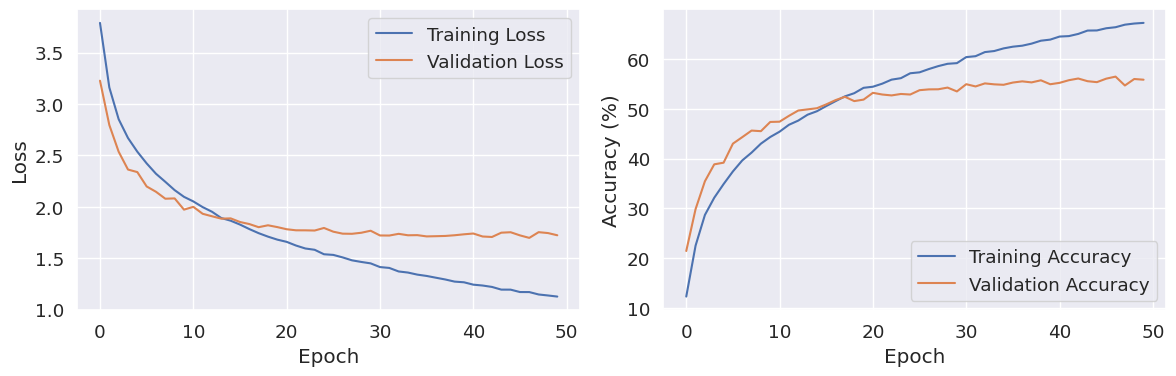

In [13]:
# Visualization
plt.figure(figsize=(12, 4))

# Plotting Training and Validation Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')  # Changed from test_losses
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')  # Changed from test_accuracies
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    matrix = confusion_matrix(y_true, y_pred)

    # Plot using Seaborn
    plt.figure(figsize=(20, 20))
    sns.set(font_scale=1.2)
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    # Only annotate cells with more than a threshold (e.g., 10) misclassifications to avoid clutter
    threshold = 10
    for i, j in zip(*np.where(matrix > threshold)):
        plt.text(j+0.5, i+0.5, matrix[i, j],
                 fontsize=12,
                 ha='center',
                 va='center',
                 color='red')

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix with Selective Annotations')
    plt.show()

In [ ]:


y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())



In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')  # Added f_score

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F-Score: {f_score:.2f}")  # Printing F-Score

In [ ]:
class_names = ['beaver', 'dolphin', 'otter', 'seal', 'whale',
'aquarium' ,'fish', 'ray', 'shark', 'trout',
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
'bottles', 'bowls', 'cans', 'cups', 'plates',
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe',
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
'bear', 'leopard', 'lion', 'tiger', 'wolf',
'bridge', 'castle', 'house', 'road', 'skyscraper',
'cloud', 'forest', 'mountain', 'plain', 'sea',
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
'crab', 'lobster', 'snail', 'spider', 'worm',
'baby', 'boy', 'girl', 'man', 'woman',
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
'maple', 'oak', 'palm', 'pine', 'willow',
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']


plot_confusion_matrix(y_true, y_pred, class_names)